# PSB injection bump in Xsuite - basics

In [1]:
%matplotlib notebook

In [2]:
# Import modules
import matplotlib.pyplot as plt
import numpy as np

import xtrack as xt
import xpart as xp
import xdeps as xd

from cpymad.madx import Madx

/Users/giadarol/xsuite_packages/xtrack/xtrack/progress_indicator.py:90: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


## Get MAD-X model

In [3]:
# Load mad thick model and apply element shifts
mad = Madx()
mad.input('''
    call, file = 'psb.seq';
    call, file = 'psb_fb_lhc.str';

    beam, particle=PROTON, pc=0.5708301551893517;
    use, sequence=psb1;
''')

# Add shifts on injection bumpers
mad.input('''
    select,flag=error,pattern=bi1.bsw1l1.1*;
    ealign, dx=-0.0057;

    select,flag=error,clear;
    select,flag=error,pattern=bi1.bsw1l1.2*;
    select,flag=error,pattern=bi1.bsw1l1.3*;
    select,flag=error,pattern=bi1.bsw1l1.4*;
    ealign, dx=-0.0442;
''')

mad.twiss() # To check that the model is fine



  ++++++++++++++++++++++++++++++++++++++++++++
  +     MAD-X 5.09.00  (64 bit, Darwin)      +
  + Support: mad@cern.ch, http://cern.ch/mad +
  + Release   date: 2023.05.05               +
  + Execution date: 2023.11.19 13:17:04      +
  ++++++++++++++++++++++++++++++++++++++++++++




  /************************************************************************************

  *

  * PS Booster version  (draft) LS2 in MAD X SEQUENCE format

  * Generated the 28-AUG-2020 16:25:27 from Layout

  *

  ************************************************************************************/







/************************************************************************************/

/*                       TYPES DEFINITION                                           */

/************************************************************************************/



//---------------------- COLLIMATOR     ---------------------------------------------

BR_SPSCRAP     : COLLIMATOR  , L := 0;         ! PSB

<Table 'twiss': {name, keyword, s, betx, alfx, mux, bety, alfy, muy, x, px, y, py, t, pt, dx, dpx, dy, dpy, wx, phix, dmux, wy, phiy, dmuy, ddx, ddpx, ddy, ddpy, r11, r12, r21, r22, energy, l, angle, k0l, k0sl, k1l, k1sl, k2l, k2sl, k3l, k3sl, k4l, k4sl, k5l, k5sl, k6l, k6sl, k7l, k7sl, k8l, k8sl, k9l, k9sl, k10l, k10sl, k11l, k11sl, k12l, k12sl, k13l, k13sl, k14l, k14sl, k15l, k15sl, k16l, k16sl, k17l, k17sl, k18l, k18sl, k19l, k19sl, k20l, k20sl, ksi, hkick, vkick, tilt, e1, e2, h1, h2, hgap, fint, fintx, volt, lag, freq, harmon, slot_id, assembly_id, mech_sep, v_pos, bbcharge, xma, yma, sigx, sigy, lrad, parent, comments, re11, re12, re13, re14, re15, re16, re21, re22, re23, re24, re25, re26, re31, re32, re33, re34, re35, re36, re41, re42, re43, re44, re45, re46, re51, re52, re53, re54, re55, re56, re61, re62, re63, re64, re65, re66, kmax, kmin, calib, polarity, alfa, beta11, beta12, beta13, beta21, beta22, beta23, beta31, beta32, beta33, alfa11, alfa12, alfa13, alfa21, alfa22, alfa

## Build Xsuite line from MAD-X model

In [4]:
# Build line (thick elements)
line = xt.Line.from_madx_sequence(mad.sequence.psb1,
                                  allow_thick=True,
                                  enable_align_errors=True,
                                  deferred_expressions=True)

# Associate reference particle to the line
line.particle_ref = xp.Particles(mass0=xp.PROTON_MASS_EV, gamma0=mad.sequence.psb1.beam.gamma)

# Switch to exact model for bends (PTC-like, approppriate for small rings)
line.configure_bend_model(core='full', edge='full')

# Build tracker (by default single-core CPU)
line.build_tracker()

Converting sequence "psb1":   0%|          | 0/528 [00:00<?, ?it/s]

Found suitable prebuilt kernel `default_only_xtrack`.


### Inspect the line elements

In [5]:
line_table = line.get_table() 

In [6]:
line_table.rows[:12] # we can see that the injection bumpers are exploded into multiple simpler elements
                     # belonging to the same compound.

Table: 12 rows, 5 cols
name                           s element_type isthick compound_name    
psb1$start                     0 Marker         False                  
p01ring1$start                 0 Marker         False                  
drift_0                        0 Drift           True                  
bi1.bsw1l1.1_entry        0.1795 Marker         False bi1.bsw1l1.1     
bi1.bsw1l1.1_offset_entry 0.1795 XYShift        False bi1.bsw1l1.1     
bi1.bsw1l1.1_den          0.1795 DipoleEdge     False bi1.bsw1l1.1     
bi1.bsw1l1.1              0.1795 Bend            True bi1.bsw1l1.1     
bi1.bsw1l1.1_dex          0.4925 DipoleEdge     False bi1.bsw1l1.1     
bi1.bsw1l1.1_offset_exit  0.4925 XYShift        False bi1.bsw1l1.1     
bi1.bsw1l1.1_exit         0.4925 Marker         False bi1.bsw1l1.1     
drift_1                   0.4925 Drift           True                  
bi1.bsw1l1.2_entry        0.8695 Marker         False bi1.bsw1l1.2     

### Twiss defaults
By default the Xsuite twiss is 6d (gives error if RF is not present).
We can set different defaults for our line, for example switch to 4d twiss, and hide group "compound elements".

In [7]:
line.twiss_default['method'] = '4d'
line.twiss_default['group_compound_elements'] = True

###  Save reload
At any moment the line can be saved to a json file and reloaded

In [8]:
# Save
line.to_json('psb_00_from_mad.json')

In [9]:
# Reload
line = xt.Line.from_json('psb_00_from_mad.json')
line.build_tracker()

Loading line from dict:   0%|          | 0/1224 [00:00<?, ?it/s]

Done loading line from dict.           
Found suitable prebuilt kernel `default_only_xtrack`.


## Working with the line (basics)

### Twiss

Use the twiss method for analyzing the line model and diagnosing issues:

In [10]:
tw = line.twiss()

Found suitable prebuilt kernel `only_xtrack_frozen_energy`.


Access scalar quantities (tunes, chromaticities, momentum compaction, rev period). For example: 

In [11]:
tw.qx, tw.qy, tw.dqy, tw.c_minus, tw.T_rev0

(4.399999999835101,
 4.450000001063194,
 -7.529903973759744,
 0.0,
 1.0080991028513366e-06)

Plot beta functions, orbit, dispersion. 

<IPython.core.display.Javascript object>


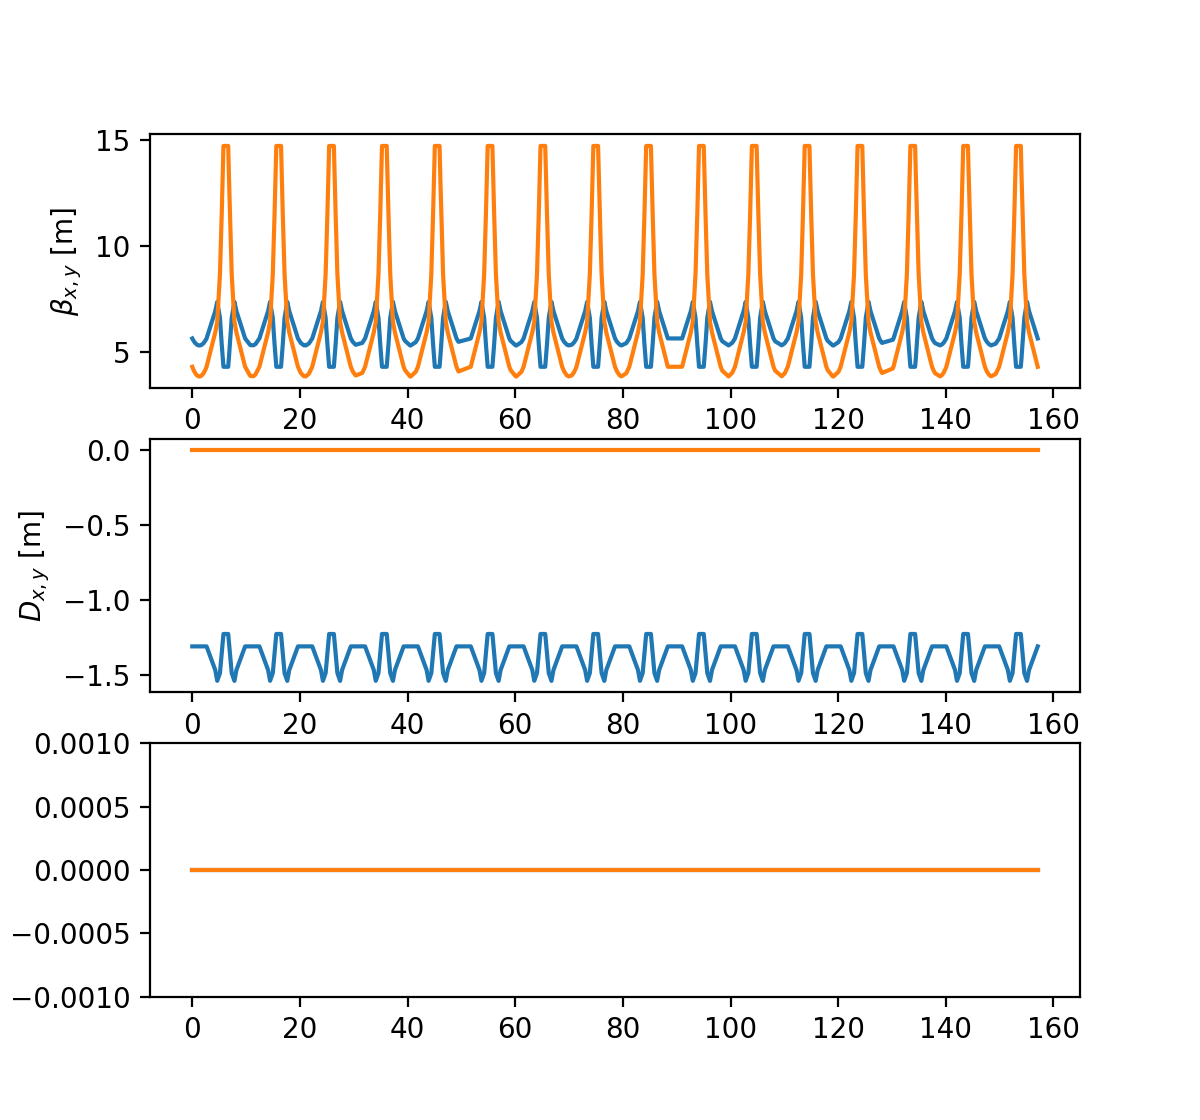

Text(0, 0.5, 'x,y [m]')

In [12]:
fig = plt.figure(1, figsize=(6, 4*1.4))
sp1 = plt.subplot(3,1,1)
sp2 = plt.subplot(3,1,2, sharex=sp1)
sp3 = plt.subplot(3,1,3, sharex=sp1)

sp1.plot(tw.s, tw.betx)
sp1.plot(tw.s, tw.bety)
sp1.set_ylabel(r'$\beta_{x,y}$ [m]')
sp2.plot(tw.s, tw.dx)
sp2.plot(tw.s, tw.dy)
sp2.set_ylabel(r'$D_{x,y}$ [m]')
sp3.plot(tw.s, tw.x)
sp3.plot(tw.s, tw.dy)
sp3.set_ylim(-1e-3, 1e-3)
sp3.set_ylabel(r'x,y [m]')

### Working with twiss tables and inspecting line elements

Twiss table support several indexing modes. Here some examples:

In [13]:
# Select rows and colums (rows selected by index)
tw.rows[20:25].cols['s', 'betx', 'bety']

TwissTable: 5 rows, 4 cols
name                            s    betx    bety
br.spscrap11_entry         4.2717 6.92258   5.922
drift_9                    4.2717 6.92258   5.922
br1.vvs1l2                4.51482 7.20282 6.24668
drift_10                  4.51482 7.20282 6.24668
br.qfo11_entry            4.63801 7.35333 6.42193

In [16]:
# Select rows and colums (rows selected by name)
tw.rows['br.spscrap11_entry':'br1.bpm1l3_entry'].cols['s', 'betx', 'bety']

TwissTable: 7 rows, 4 cols
name                            s    betx    bety
br.spscrap11_entry         4.2717 6.92258   5.922
drift_9                    4.2717 6.92258   5.922
br1.vvs1l2                4.51482 7.20282 6.24668
drift_10                  4.51482 7.20282 6.24668
br.qfo11_entry            4.63801 7.35333 6.42193
drift_11                  5.14158 6.60335 8.65233
br1.bpm1l3_entry           5.4678   5.371 11.4618

In [17]:
# Select rows and colums (rows selected by `s` range)
tw.rows[150.:153.:'s'].cols['s', 'betx', 'bety']

TwissTable: 10 rows, 4 cols
name                            s    betx    bety
drift_190                 151.534 6.92258   5.922
br.stscrap161_entry       151.534 6.92258   5.922
drift_191                 151.534 6.92258   5.922
br.qfo161_entry           151.901 7.35333 6.42193
drift_192                 152.404 6.60335 8.65233
br1.bpm16l3_entry          152.73 5.37085 11.4622
br1.onoh0.16l3_entry       152.73 5.37085 11.4622
br1.qno16l3_entry          152.73 5.37085 11.4622
br1.xnoh0.16l3_entry       152.73 5.37085 11.4622
drift_193                  152.73 5.37085 11.4622

In [18]:
# Select rows and colums (rows selected with regular expression)
tw.rows['.*bsw1l.*'].cols['s', 'betx', 'bety']

TwissTable: 4 rows, 4 cols
name                           s    betx    bety
bi1.bsw1l1.1_entry        0.1795 5.54877 4.18088
bi1.bsw1l1.2_entry        0.8695  5.3394 3.89298
bi1.bsw1l1.3_entry        1.3975 5.30053 3.84019
bi1.bsw1l1.4_entry        2.0935 5.41004 3.99253

Line elements can be inspected with:

In [19]:
line['br.bhz21']

Bend(k0=-0.12137604398438401, h=-0.12137604398438401, length=1.617696, knl=[0. 0. 0. 0. 0.], ksl=[0. 0. 0. 0. 0.], num_multipole_kicks=0, _order=4, inv_factorial_order=0.041666666666666664, _model=1)

### Deferred expressions imported from MAD-X

MAD-X deferred expressions are imported as variables attached to the line. For example:

In [20]:
line.vars['k0bi1bsw1l11']._info()

#  vars['k0bi1bsw1l11']._get_value()
   vars['k0bi1bsw1l11'] = 0.0

#  vars['k0bi1bsw1l11']._expr is None

#  vars['k0bi1bsw1l11']._find_dependant_targets()
   element_refs['bi1.bsw1l1.1_dex'].k
   element_refs['bi1.bsw1l1.1_dex'].e1_fd
   element_refs['bi1.bsw1l1.1'].k0
   element_refs['bi1.bsw1l1.1_den'].k
   element_refs['bi1.bsw1l1.1_den'].e1_fd



We can set/read variables as follows:

In [21]:
line.vars['k0bi1bsw1l11'] = 0.1

In [22]:
print(line['bi1.bsw1l1.1'].k0)
print(line['bi1.bsw1l1.1_den'].r43)

0.1
-0.0015651277804227016


In [23]:
line.vars['k0bi1bsw1l11'] = 0.

In [24]:
print(line['bi1.bsw1l1.1'].k0)
print(line['bi1.bsw1l1.1_den'].r43)

0.0
-0.0


Knobs attached to the elements can be inspected or modified through `line.element_refs`. For example

In [25]:
line.element_refs['bi1.bsw1l1.1'].k0._info()

#  element_refs['bi1.bsw1l1.1'].k0._get_value()
   element_refs['bi1.bsw1l1.1'].k0 = 0.0

#  element_refs['bi1.bsw1l1.1'].k0._expr
   element_refs['bi1.bsw1l1.1'].k0 = vars['k0bi1bsw1l11']

#  element_refs['bi1.bsw1l1.1'].k0._expr._get_dependencies()
   vars['k0bi1bsw1l11'] = 0.0

#  element_refs['bi1.bsw1l1.1'].k0 does not influence any target



### Match parameters

Variables can be used to optimize settings as to obtain certain targets in the twiss results (match). For example we can match the tunes:

In [26]:
info = line.match(
    targets=[
        xt.Target('qx',  4.2, tol=1e-6),
        xt.Target('qy',  4.3, tol=1e-6)],
    vary=[
        xt.Vary('kbrqf', step=1e-5),
        xt.Vary('kbrqd', step=1e-5)],
)

Matching: model call n. 12       



In [27]:
# Check
tw = line.twiss()
tw.qx, tw.qy

(4.199999999529853, 4.299999999994372)

---------

In [28]:
line.element_refs['bi1.bsw1l1.1'].k0._info()

#  element_refs['bi1.bsw1l1.1'].k0._get_value()
   element_refs['bi1.bsw1l1.1'].k0 = 0.0

#  element_refs['bi1.bsw1l1.1'].k0._expr
   element_refs['bi1.bsw1l1.1'].k0 = vars['k0bi1bsw1l11']

#  element_refs['bi1.bsw1l1.1'].k0._expr._get_dependencies()
   vars['k0bi1bsw1l11'] = 0.0

#  element_refs['bi1.bsw1l1.1'].k0 does not influence any target



In [29]:
line['bi1.bsw1l1.1'].k0 = 3

In [30]:
line['bi1.bsw1l1.1'].k0


3.0

In [31]:
line.vars['k0bi1bsw1l11'] = 4

In [32]:
line['bi1.bsw1l1.1'].k0

4.0

In [33]:
line.element_refs['bi1.bsw1l1.1'].k0 = 6

In [34]:
line['bi1.bsw1l1.1'].k0

6.0

In [35]:
line.vars['k0bi1bsw1l11'] = 4

In [36]:
line['bi1.bsw1l1.1'].k0

6.0

In [37]:
line.vars['hello'] = 4

In [38]:
line.element_refs['bi1.bsw1l1.1'].k0 = 2* line.vars['hello']

In [39]:
line['bi1.bsw1l1.1'].k0


8.0

In [40]:
line.vars['hello'] = 7

In [41]:
line['bi1.bsw1l1.1'].k0

14.0

In [42]:
line.element_refs['bi1.bsw1l1.1'].k0._info()

#  element_refs['bi1.bsw1l1.1'].k0._get_value()
   element_refs['bi1.bsw1l1.1'].k0 = 14.0

#  element_refs['bi1.bsw1l1.1'].k0._expr
   element_refs['bi1.bsw1l1.1'].k0 = (2*vars['hello'])

#  element_refs['bi1.bsw1l1.1'].k0._expr._get_dependencies()
   vars['hello'] = 7

#  element_refs['bi1.bsw1l1.1'].k0 does not influence any target

